## Project: Identify Fraud from Enron Email

### Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, I will apply machine learning techniques to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal, which could help us  to identify any potential person in the fraud case based on the available data we collected. 

In order to wrap up this detective work, we do have a list of person that are already tagged with 'fraud' as they were addicted, reached a settlement or peal deal with the government, or testified in exchange for prosecution immunity.

### Problem Clarification

Identify persons who are in the corporate fraud based on the available data within financial features, email features, and available 'poi' labels.

### Method and Process

<ul>
<li>[Part 1 Data Overview](### Dataset Overview)
<li>[Part 2 Feature Preprocessing](#Part-2-Feature-Preprocessing)
<li>[Part 3 New Feature Creation](#Part-3-New-Feature-Creation)
<li>[Part 4 Feature Selection](#Part-4:-Feature-Selection)
<li>[Part 5 Modelling Training](#Part-5:-Modelling-Training)
<li>[Part 6 Result](#Part-6:-Result)
</ul>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

import sys
sys.path.append("../tools/")
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sb
import pickle

import warnings
warnings.filterwarnings('ignore')

### Part1: Dataset Overview

#### Dataset overivew

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
data=pd.DataFrame.from_dict(data_dict,orient='index')  # read the data and traverse the columns and rows

In [5]:
finance_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock',
                 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
              'shared_receipt_with_poi']

poi_feature=['poi']

feature_list=poi_feature + finance_features + email_features

In [6]:
#reorder the features
data=data.ix[:,feature_list]

In [7]:
data.head()

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,email_address,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
ALLEN PHILLIP K,False,201955,2869717,4484442,NaN,4175000,-126027,-3081055,1729541,13868,1729541,152,304805,126027,NaN,2902,phillip.allen@enron.com,47,2195,65,1407
BADUM JAMES P,False,NaN,178980,182466,NaN,NaN,NaN,NaN,257817,3486,257817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477,NaN,916197,NaN,NaN,-560222,-5104,5243487,56301,4046157,864523,NaN,1757552,NaN,566,james.bannantine@enron.com,39,29,0,465
BAXTER JOHN C,False,267102,1295738,5634343,NaN,1200000,NaN,-1386055,10623258,11200,6680544,2660303,1586055,3942714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BAY FRANKLIN R,False,239671,260455,827696,NaN,400000,-82782,-201641,63014,129142,NaN,69,NaN,145796,NaN,NaN,frank.bay@enron.com,NaN,NaN,NaN,NaN


#### Data Type

In [8]:
data_type=[bool]+[np.float]*15+[str]+[np.float]*4

In [9]:
for i in range(len(feature_list)):
    data[feature_list[i]]=data[feature_list[i]].astype(data_type[i])

In [10]:
print "Num of rows: " + str(data.shape[0]) # row count
print "Num of columns: " + str(data.shape[1]) # col count

Num of rows: 146
Num of columns: 21


For the dataset we had, there are 146 records and 21 variables. 

The 21 variables including financial features, email features,poi labels, which I listed below,

- financial features(14)

['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

- Email features(6)

['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] 
(units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

- POI label(1)

[‘poi’] (boolean, represented as integer)


- Number of the people who are labeled as poi

In [11]:
data.loc[data.poi==True,'poi'].count()

18

### Part 2:  Feature Preprocessing

#### Null value check in the dataset

Considering there are only 146 people in the dataset, most of people has no data in the loan_advances,director_fees,restricted_stock_deferred variables.

In [12]:
data.isnull().sum()/data.shape[0]

poi                          0.000000
salary                       0.349315
deferral_payments            0.732877
total_payments               0.143836
loan_advances                0.972603
bonus                        0.438356
restricted_stock_deferred    0.876712
deferred_income              0.664384
total_stock_value            0.136986
expenses                     0.349315
exercised_stock_options      0.301370
other                        0.363014
long_term_incentive          0.547945
restricted_stock             0.246575
director_fees                0.883562
to_messages                  0.410959
email_address                0.000000
from_poi_to_this_person      0.410959
from_messages                0.410959
from_this_person_to_poi      0.410959
shared_receipt_with_poi      0.410959
dtype: float64

In [13]:
data.isnull().sum(axis=1).sort_values(ascending=False).head()

LOCKHART EUGENE E                19
GRAMM WENDY L                    17
WROBEL BRUCE                     17
WODRASKA JOHN                    17
THE TRAVEL AGENCY IN THE PARK    17
dtype: int64

As what we could see, only email_address have no nan value, and the info that person missed most is LOCKHART EUGENE E who only had poi labels and email address, which we could remove later. 

For the nan value filling, 

In [14]:
data.loc[:,finance_features].isnull().sum()

salary                        51
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
exercised_stock_options       44
other                         53
long_term_incentive           80
restricted_stock              36
director_fees                129
dtype: int64

In [15]:
data.loc[:,email_features].isnull().sum()

to_messages                60
email_address               0
from_poi_to_this_person    60
from_messages              60
from_this_person_to_poi    60
shared_receipt_with_poi    60
dtype: int64

we could see the number of missing value in the email features are the same, which means there are certain people consistently missing in the email features. Of them, there are some people are labeled as poi, and their email features might be lost by means. So, I will fill out those null value related to email features with median value.

In [16]:
data[email_features] = data[email_features].fillna(data[email_features].median())

For the financial features, the info are missing in different variables for different people, and the value could be 0 if the null value in the table. So, I will fill in 0 if it is null.

In [17]:
data[finance_features] = data[finance_features].fillna(0)

#### Outliers Detection & Removal

In [18]:
data.describe()

,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
count,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,146.000000,146.000000
mean,3.658114e+05,4.387965e+05,4.350622e+06,1.149658e+06,1.333474e+06,2.051637e+04,-3.827622e+05,5.846018e+06,7.074827e+04,4.182736e+06,5.854318e+05,6.646839e+05,1.749257e+06,1.942249e+04,1719.260274,52.609589,375.452055,27.575342,997.301370
std,2.203575e+06,2.741325e+06,2.693448e+07,9.649342e+06,8.094029e+06,1.439661e+06,2.378250e+06,3.624681e+07,4.327163e+05,2.607040e+07,3.682345e+06,4.046072e+06,1.089995e+07,1.190543e+05,2022.788673,68.210867,1437.174998,78.357081,927.488807
min,0.000000e+00,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-7.576788e+06,-2.799289e+07,-4.409300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,0.000000e+00,57.000000,0.000000,12.000000,0.000000,2.000000
25%,0.000000e+00,0.000000e+00,9.394475e+04,0.000000e+00,0.000000e+00,0.000000e+00,-3.792600e+04,2.288695e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.115000e+03,0.000000e+00,904.250000,25.750000,36.000000,6.000000,591.500000
50%,2.105960e+05,0.000000e+00,9.413595e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000e+00,9.659550e+05,2.018200e+04,6.082935e+05,9.595000e+02,0.000000e+00,3.605280e+05,0.000000e+00,1211.000000,35.000000,41.000000,8.000000,740.500000
75%,2.708505e+05,9.684500e+03,1.968287e+06,0.000000e+00,8.000000e+05,0.000000e+00,0.000000e+00,2.319991e+06,5.374075e+04,1.714221e+06,1.506065e+05,3.750648e+05,8.145280e+05,0.000000e+00,1585.750000,40.750000,51.250000,13.750000,893.500000
max,2.670423e+07,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,0.000000e+00,4.345095e+08,5.235198e+06,3.117640e+08,4.266759e+07,4.852193e+07,1.303223e+08,1.398517e+06,15149.000000,528.000000,14368.000000,609.000000,5521.000000


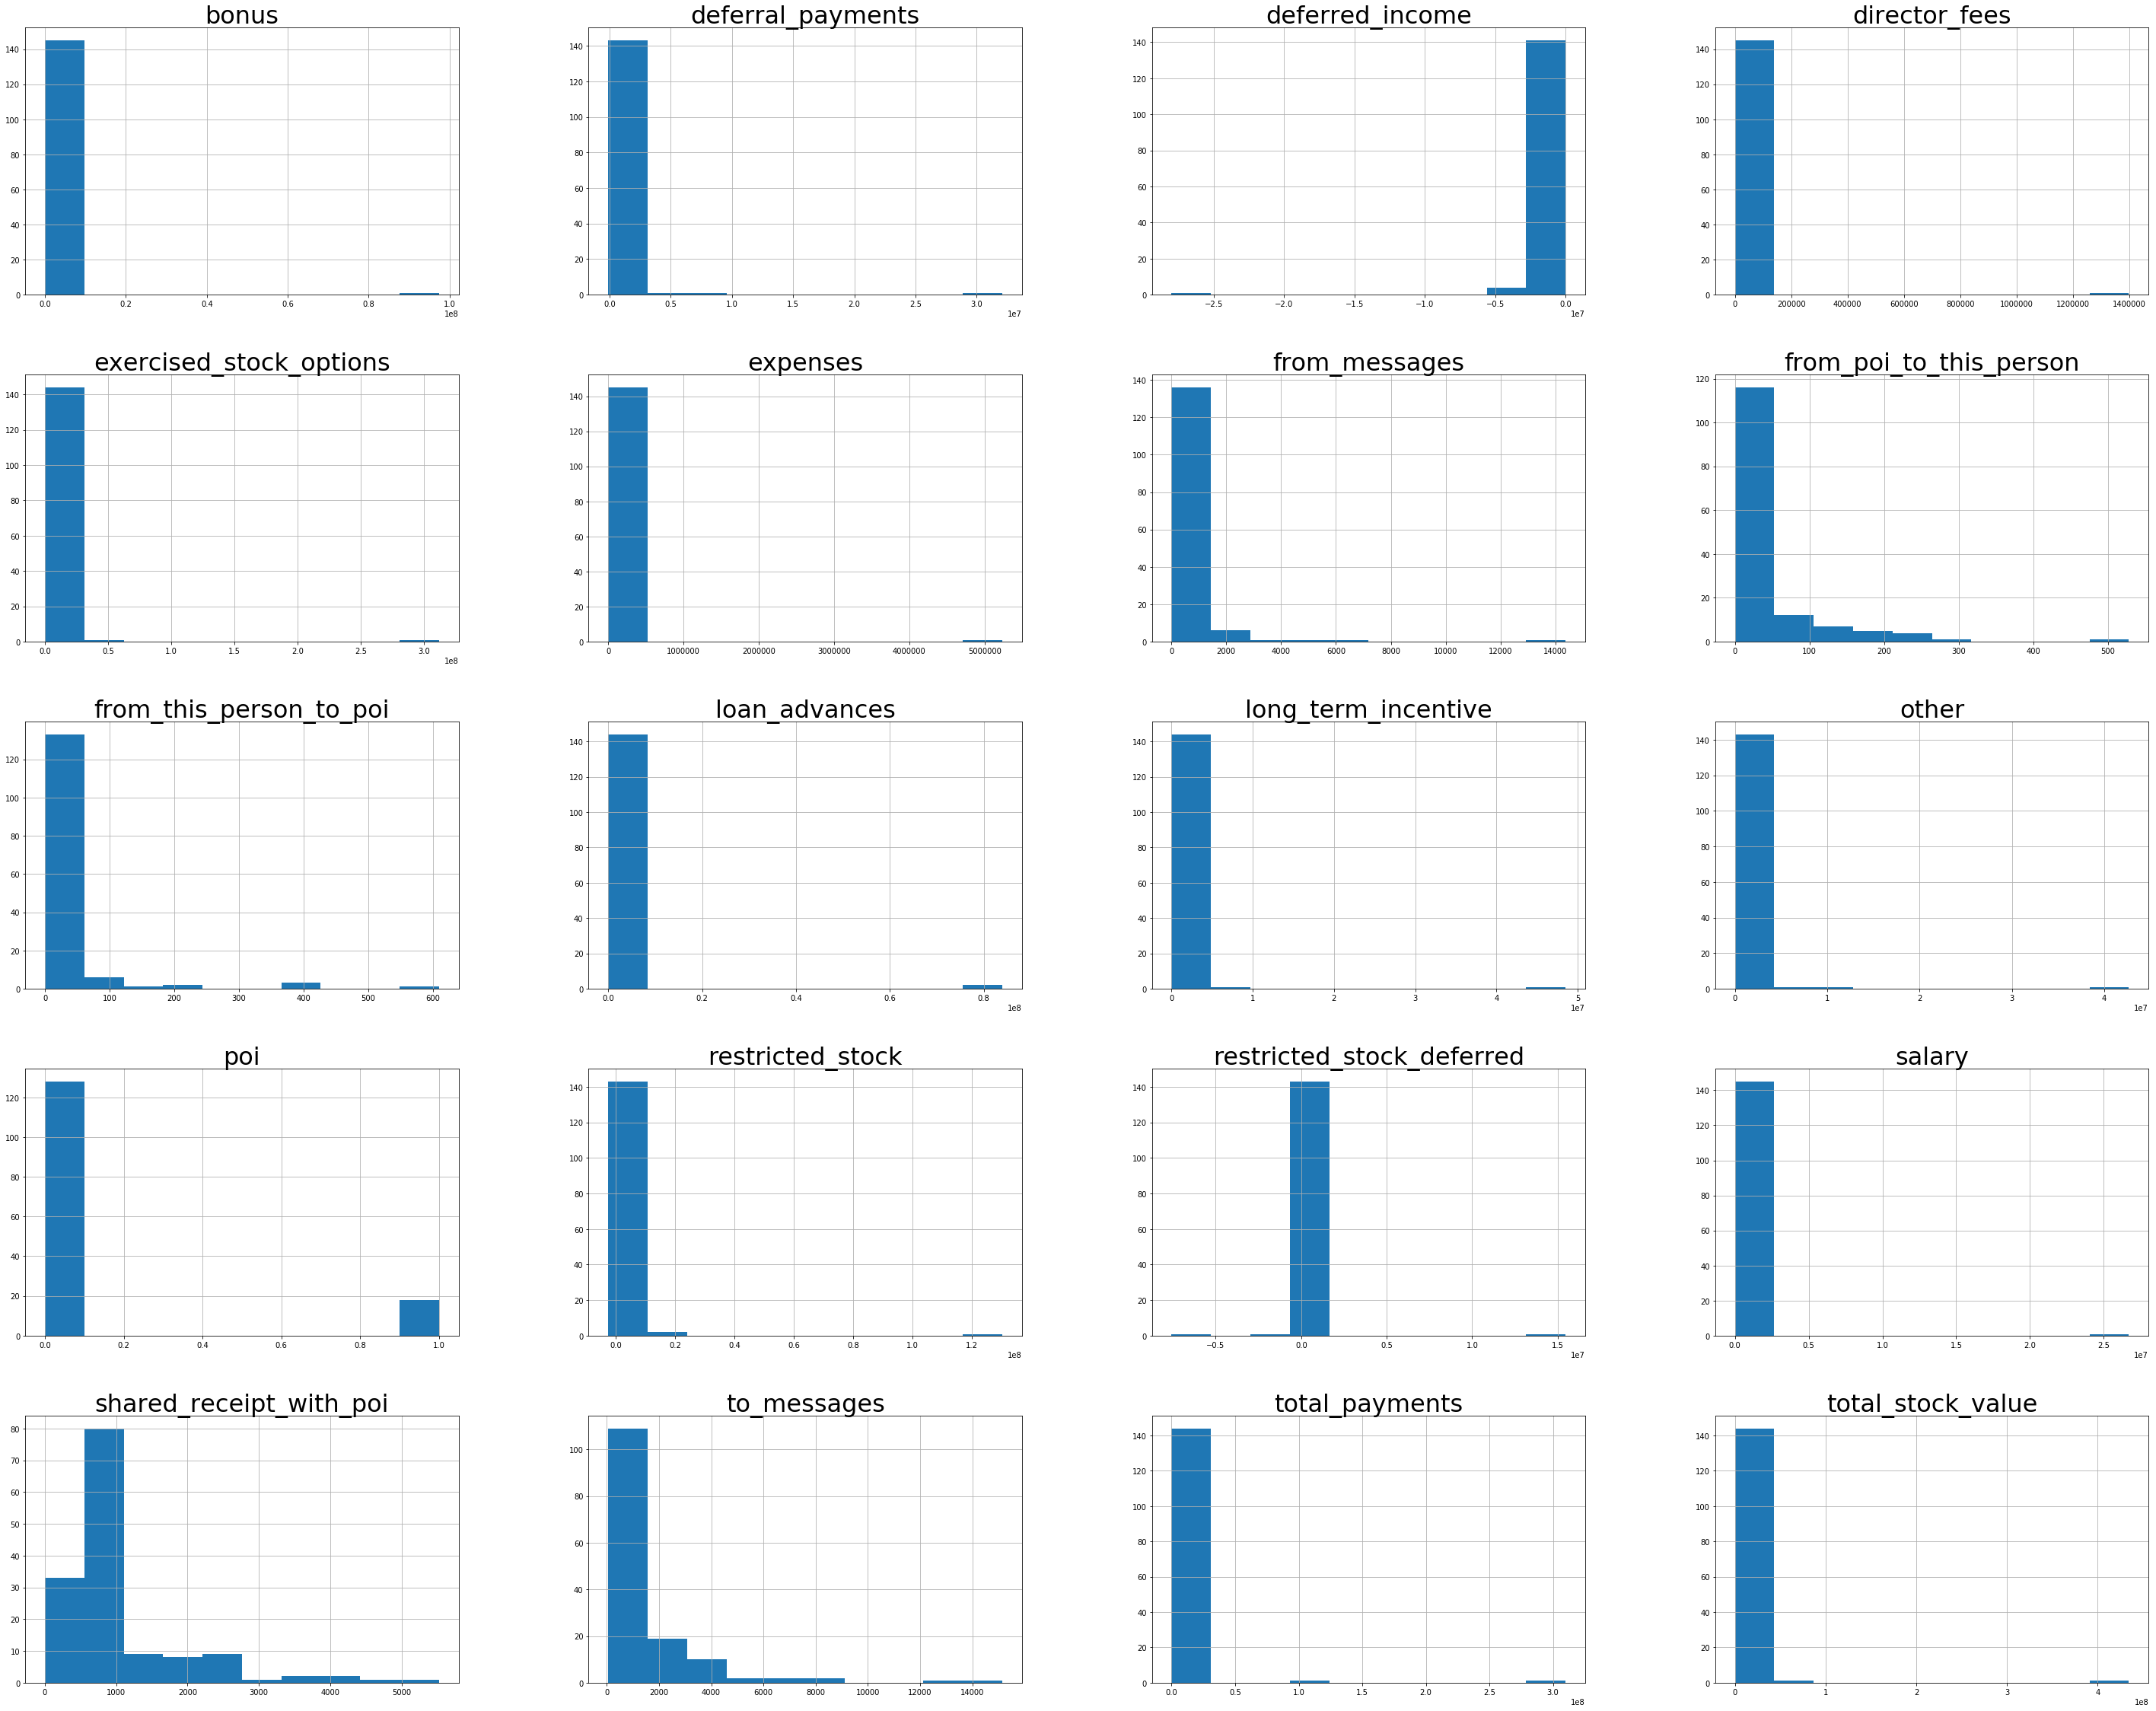

In [19]:
fig=data.hist(figsize=(50, 40))
#fig=data2.hist(figsize=(50, 40))
draw=[x.title.set_size(32) for x in fig.ravel()]

- Finance Features

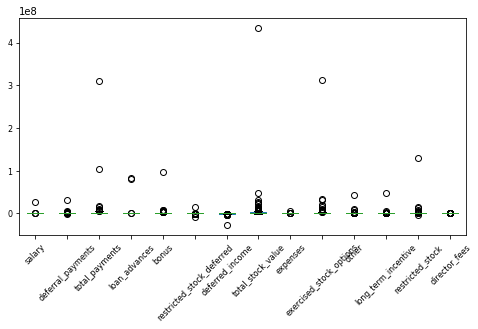

In [20]:
data.iloc[:,range(1,15)].plot(kind='box', figsize=[8,4],fontsize=8,rot=45)

- Email Features

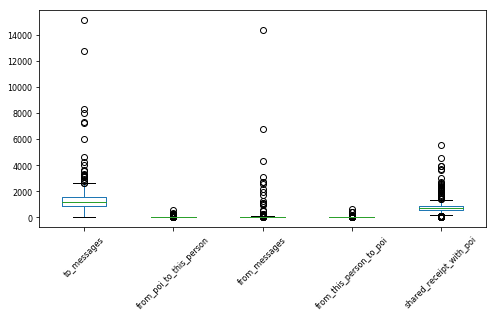

In [21]:
data.iloc[:,[15]+range(17,21)].plot(kind='box', figsize=[8,4],fontsize=8,rot=45)

In [22]:
#data2.iloc[:,range(0,14)].plot(kind='box', figsize=[8,4],fontsize=8,rot=45)
#data2.iloc[:,range(14,19)].plot(kind='box', figsize=[8,4],fontsize=8,rot=45)

As what we could noticed from the graph above, we could notice the dataset definitely exists outliers. Here we could see those outliers should be removed,

- TOTAL: This row is the sum of each variable, which need to removed.
- LOCKHART EUGENE E: Except the POI label(false), there is no data in all other variables.
- THE TRAVEL AGENCY IN THE PARK: Not related to the person based on the name.

In [23]:
data.iloc[:,2].sort_values(ascending=False).head()

TOTAL               32083396.0
FREVERT MARK A       6426990.0
HORTON STANLEY C     3131860.0
HUMPHREY GENE E      2964506.0
ALLEN PHILLIP K      2869717.0
Name: deferral_payments, dtype: float64

In [24]:
data.loc['LOCKHART EUGENE E',]

poi                          False
salary                           0
deferral_payments                0
total_payments                   0
loan_advances                    0
bonus                            0
restricted_stock_deferred        0
deferred_income                  0
total_stock_value                0
expenses                         0
exercised_stock_options          0
other                            0
long_term_incentive              0
restricted_stock                 0
director_fees                    0
to_messages                   1211
email_address                  NaN
from_poi_to_this_person         35
from_messages                   41
from_this_person_to_poi          8
shared_receipt_with_poi      740.5
Name: LOCKHART EUGENE E, dtype: object

Also, after checking all the columns, BELFER ROBERT and BHATNAGAR SANJAY might have the data misalighment in total_stock_value, restricted_stock, and deferral_payments, which only these two variables contain the negative value in that three variables.

In [25]:
data.iloc[:,2].sort_values().head()
data.iloc[:,8].sort_values().head()
data.iloc[:,13].sort_values().head()

#data.iloc[:,8].sort_values().head()
#total_stock_value  8   BELFER ROBERT
#restricted_stock  13   BHATNAGAR SANJAY
#deferral_payments  2- BELFER ROBERT
#data.loc['BELFER ROBERT',]
#data.loc['BHATNAGAR SANJAY',]

BHATNAGAR SANJAY          -2604490.0
YEAP SOON                        0.0
PICKERING MARK R                 0.0
PEREIRA PAULO V. FERRAZ          0.0
MEYER JEROME J                   0.0
Name: restricted_stock, dtype: float64

In [26]:
data.loc['BHATNAGAR SANJAY',]

poi                                               False
salary                                                0
deferral_payments                                     0
total_payments                              1.54563e+07
loan_advances                                         0
bonus                                                 0
restricted_stock_deferred                   1.54563e+07
deferred_income                                       0
total_stock_value                                     0
expenses                                              0
exercised_stock_options                     2.60449e+06
other                                            137864
long_term_incentive                                   0
restricted_stock                           -2.60449e+06
director_fees                                    137864
to_messages                                         523
email_address                sanjay.bhatnagar@enron.com
from_poi_to_this_person                         

In [27]:
data=data[(data.index!='TOTAL')]
data=data[(data.index!='LOCKHART EUGENE E')]
data=data[(data.index!='THE TRAVEL AGENCY IN THE PARK')]

In [28]:
data.loc['BHATNAGAR SANJAY','restricted_stock']=-data.loc['BHATNAGAR SANJAY','restricted_stock']
data.loc['BELFER ROBERT','total_stock_value']=-data.loc['BELFER ROBERT','total_stock_value']
data.loc['BELFER ROBERT','restricted_stock']=-data.loc['BELFER ROBERT','restricted_stock']

### Part 3:  Additional Features Creation

Intuitively, we know that the number of emails sent to or received from POI is important for us to indentify the potential POI if we know some one is labeled as POI.

For the features related to the email and poi, it would be much better to represent in percentage way. For from_messages variables, it 

- received_from_poi_ratio: Received from poi/all message the person received (to_messages: the person was included in the to part)
- sent_to_poi_ratio: Sent to poi /all message the person sent (from_messages: the person was included in the from part)
- shared_receipt_with_poi_ratio: 'shared_receipt_with_poi'/'to_messages'[only one record is over 1, which might be a typero, here I just assumed it is 1]

In [29]:
data['received_from_poi_ratio']=data['from_poi_to_this_person']/data['to_messages']
data['sent_to_poi_ratio']=data['from_this_person_to_poi']/data['from_messages']
data['shared_receipt_with_poi_ratio']=data['shared_receipt_with_poi']/data['to_messages']

In [30]:
data['received_from_poi_ratio'].sort_values(ascending=False).head()

DONAHUE JR JEFFREY M    0.217341
DEFFNER JOSEPH M        0.161064
COLWELL WESLEY          0.136519
REDMOND BRIAN L         0.122083
DIETRICH JANET R        0.118585
Name: received_from_poi_ratio, dtype: float64

In [31]:
data['sent_to_poi_ratio'].sort_values(ascending=False).head()

HUMPHREY GENE E       1.000000
SHERRICK JEFFREY B    0.720000
HANNON KEVIN P        0.656250
GARLAND C KEVIN       0.613636
RIEKER PAULA H        0.585366
Name: sent_to_poi_ratio, dtype: float64

In [32]:
data['shared_receipt_with_poi_ratio'].sort_values(ascending=False).head()

GLISAN JR BEN F    1.001145
HANNON KEVIN P     0.990431
SUNDE MARTIN       0.969022
KOENIG MARK E      0.956613
RICE KENNETH D     0.954696
Name: shared_receipt_with_poi_ratio, dtype: float64

### Part 4: Feature selection

In [33]:
import seaborn as sb
corr=data.corr()
corr

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi,received_from_poi_ratio,sent_to_poi_ratio,shared_receipt_with_poi_ratio
poi,1.000000,0.338851,-0.039880,0.242020,0.220183,0.358486,-0.021548,-0.274150,0.382604,0.203545,0.386853,0.169829,0.256405,0.242745,-0.121886,0.078147,0.170582,-0.036664,0.123589,0.223100,0.108427,0.288676,0.228179
salary,0.338851,1.000000,0.242486,0.511317,0.388443,0.648715,-0.089183,-0.329262,0.520906,0.358144,0.448741,0.544787,0.559334,0.524957,-0.305364,0.324901,0.345583,0.138092,0.189497,0.443302,0.124683,0.129174,0.206958
deferral_payments,-0.039880,0.242486,1.000000,0.141078,0.014509,0.173795,-0.030513,-0.543115,0.118197,-0.021808,0.117192,0.368698,0.119072,0.083111,-0.095386,0.094472,0.198518,0.026744,-0.005301,0.186455,0.072302,0.069033,0.044646
total_payments,0.242020,0.511317,0.141078,1.000000,0.964305,0.559531,0.127582,-0.103456,0.661505,0.150690,0.598725,0.830105,0.520313,0.635638,-0.026504,0.174581,0.197022,0.006684,0.055281,0.236661,-0.002791,0.130594,0.029655
loan_advances,0.220183,0.388443,0.014509,0.964305,1.000000,0.432525,-0.004905,-0.025184,0.630305,0.121469,0.568214,0.759406,0.402115,0.584563,-0.027745,0.106226,0.090993,-0.020704,-0.013475,0.130868,-0.012560,0.132960,-0.014186
bonus,0.358486,0.648715,0.173795,0.559531,0.432525,1.000000,-0.043467,-0.330985,0.460612,0.243870,0.415811,0.383152,0.497030,0.416394,-0.177496,0.477363,0.612999,0.169924,0.437479,0.642261,0.081763,0.112762,0.118197
restricted_stock_deferred,-0.021548,-0.089183,-0.030513,0.127582,-0.004905,-0.043467,1.000000,0.047988,-0.045276,-0.067996,-0.002355,-0.007366,-0.039044,0.068385,0.346195,-0.048455,-0.065988,-0.023412,-0.025693,-0.048171,-0.095137,-0.066484,0.100386
deferred_income,-0.274150,-0.329262,-0.543115,-0.103456,-0.025184,-0.330985,0.047988,1.000000,-0.244217,-0.039982,-0.268070,-0.265277,-0.295815,-0.120796,0.076548,-0.094150,-0.176887,-0.012481,0.002251,-0.220116,-0.070045,-0.096518,-0.199225
total_stock_value,0.382604,0.520906,0.118197,0.661505,0.630305,0.460612,-0.045276,-0.244217,1.000000,0.151427,0.963876,0.634445,0.420772,0.777930,-0.147469,0.118138,0.138768,-0.012657,0.019538,0.164943,0.003702,0.119527,0.058316
expenses,0.203545,0.358144,-0.021808,0.150690,0.121469,0.243870,-0.067996,-0.039982,0.151427,1.000000,0.120587,0.137773,0.095488,0.166662,-0.139616,0.230145,0.127826,0.153611,0.128861,0.282533,0.050452,0.007256,0.203860


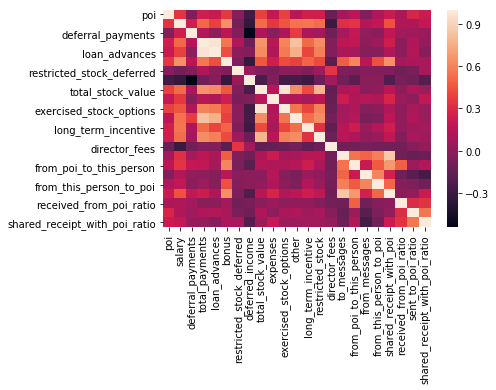

In [34]:
sb.heatmap(corr)

Referred to the heatmap and nan value I checked above, as most of loan_advances,director_fees,restricted_stock_deferred variables are nan value, which might impact its original correlation. 

Below are several features correlation visualization sample I checked out. 

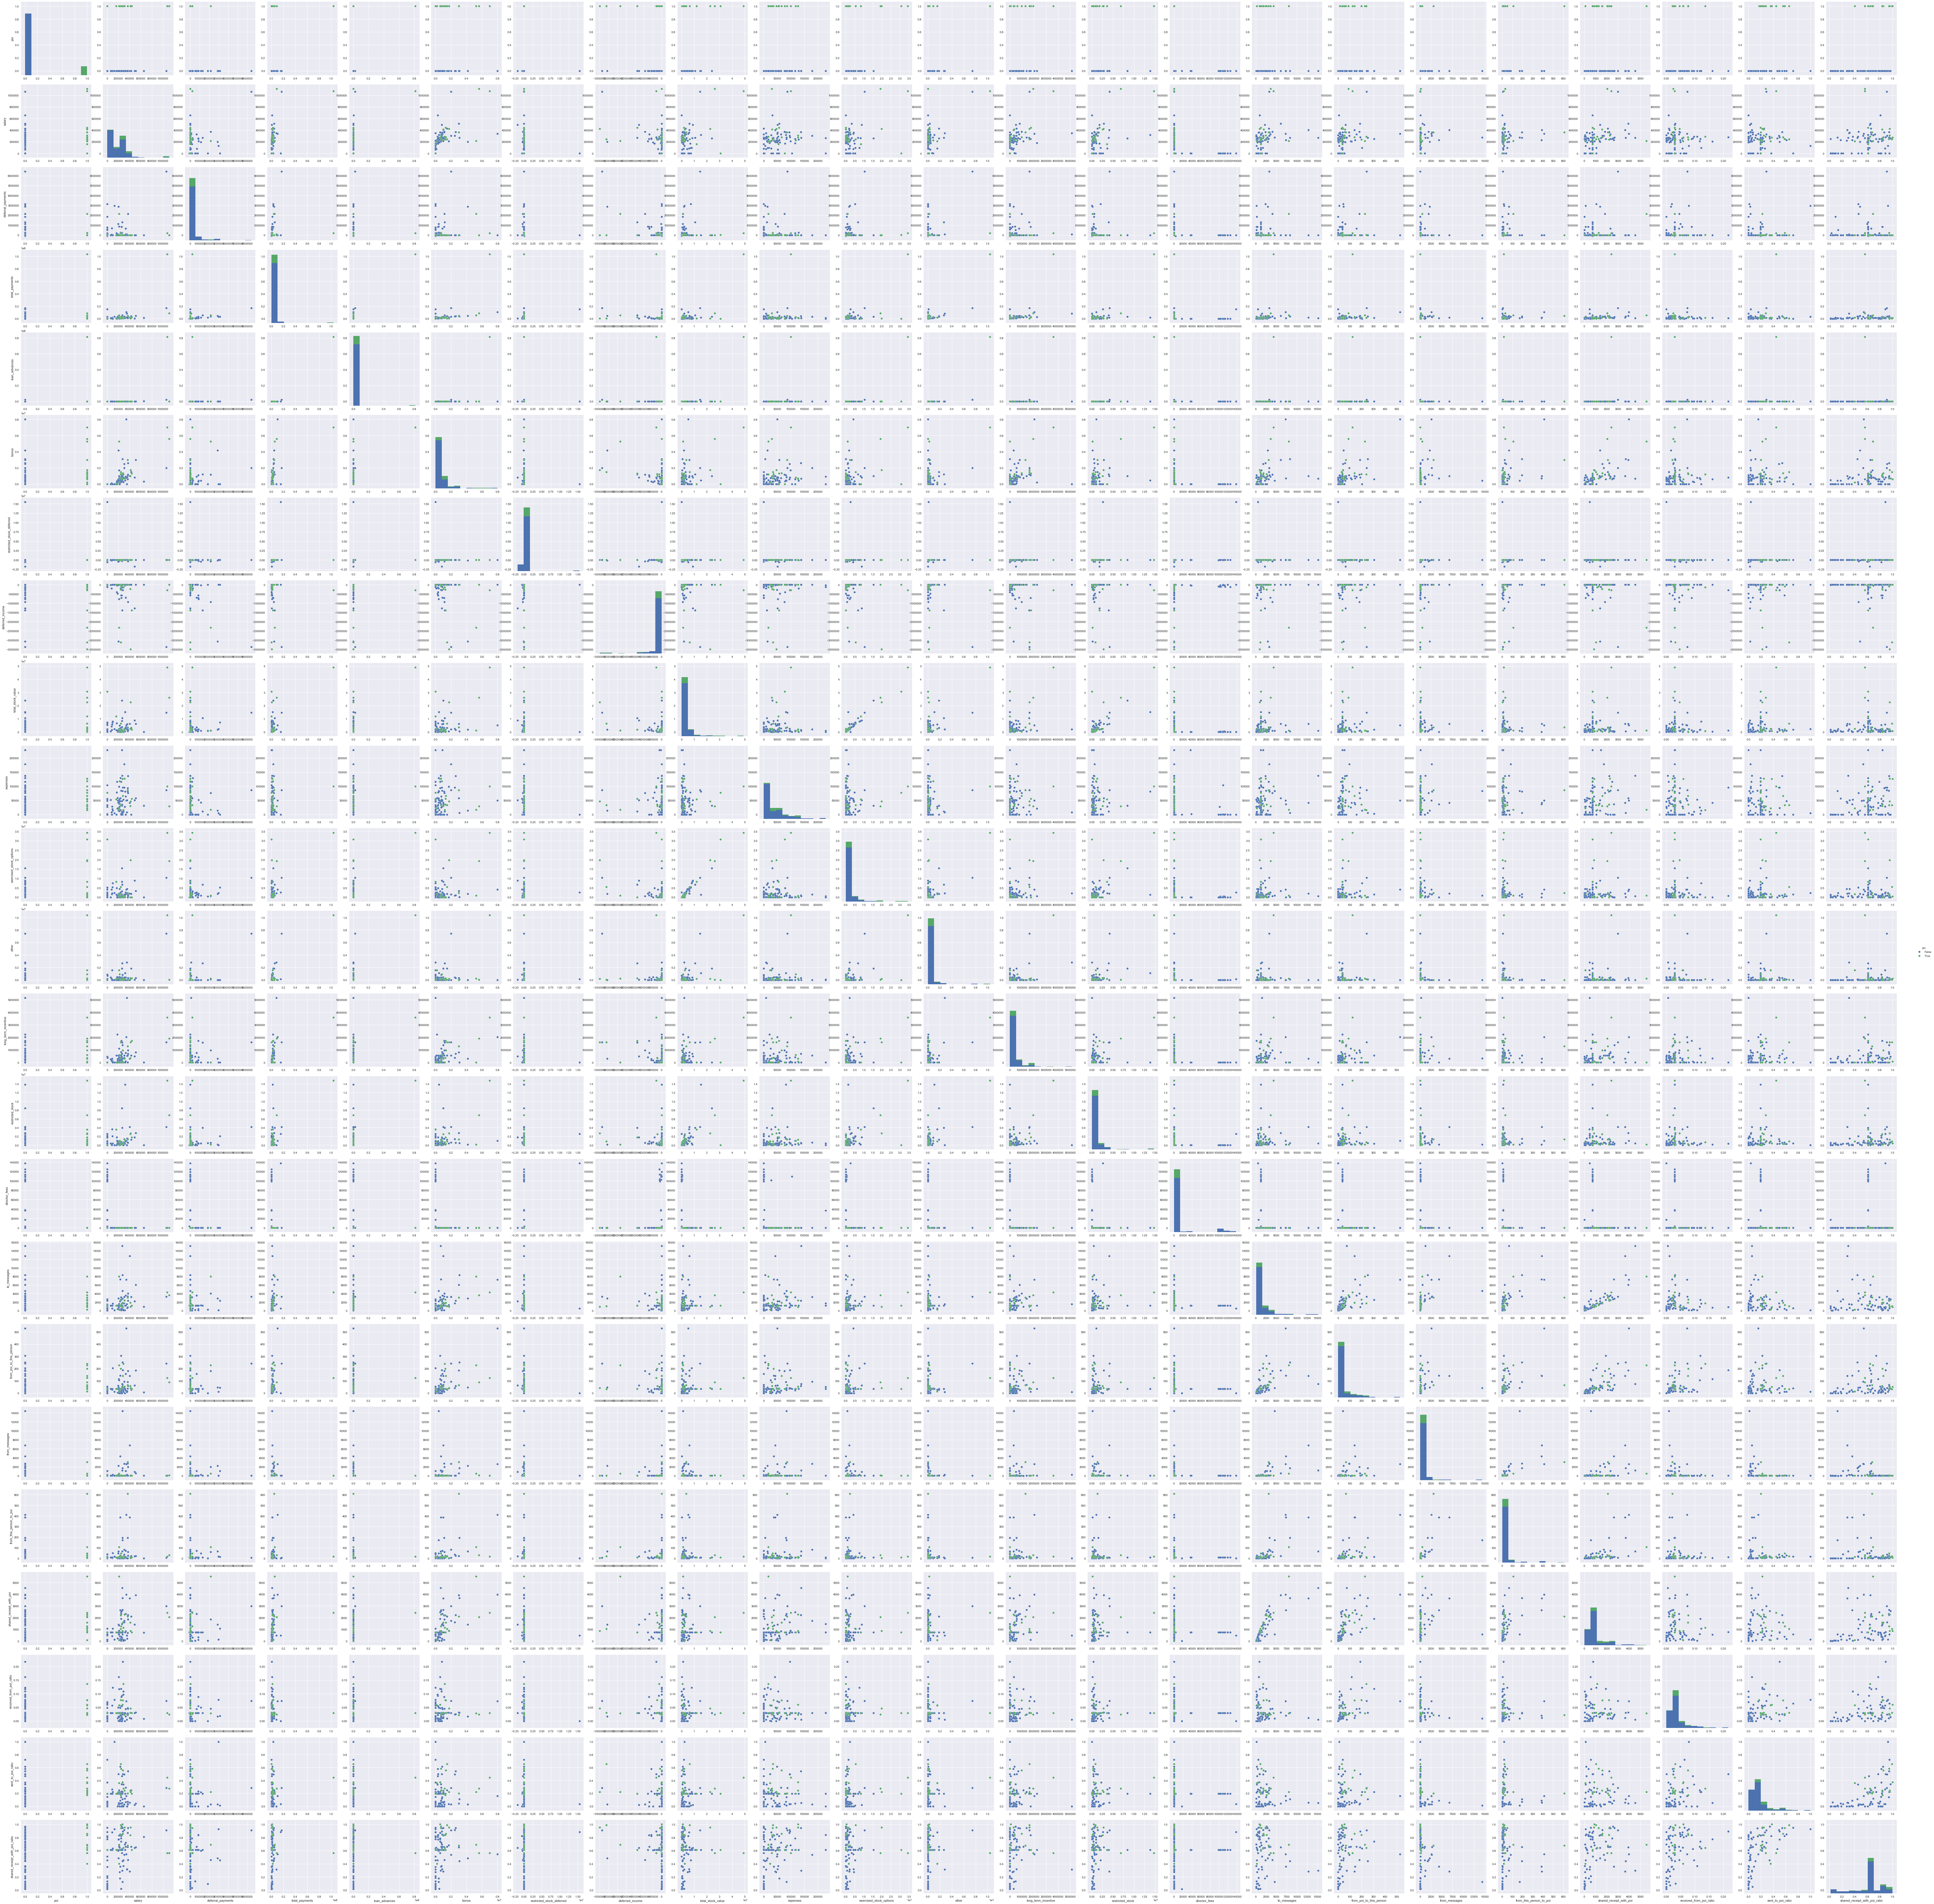

In [35]:
import seaborn as sns
sns.set()
sns.pairplot(data, hue="poi",size=4)

#### Select Features

Based on below three ways, we could see towards to the POI labels, the financial features are more significant compared to the email features in general. But as the new features we added, the features right now are more incorporated from financial and email features. 

In [36]:
# Fill all the Nan value with 0
# Removing the label feature and the email address variable, we will scale all the left features.
X = data.drop(['poi', 'email_address'], axis=1)
features=X.columns.values
y= data.poi


From the results, we could notify the features with lowest scores,which in common are below, and I will remove them from my features.

- restricted_stock_deferred	
- from_message
- to_message
- deferral_payments	
- director_fees	

#### KBest

In [37]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k='all')
selector.fit(X, y)
#selector.scores_

# Get the raw p-values for each feature, and transform from p-values into scores
#scores = -np.log10(selector.pvalues_)
scores =selector.scores_
# Organiza the result and set the features as the index in the dataframe
select_score_1 = pd.DataFrame({'features': features,
                    'scores': scores})
select_score_1.set_index(['features'])
select_score_1=select_score_1.sort_values(['scores'],ascending=0)
select_score_1

,features,scores
9,exercised_stock_options,24.815080
7,total_stock_value,24.179972
4,bonus,20.792252
0,salary,18.289684
20,sent_to_poi_ratio,12.818278
6,deferred_income,11.458477
11,long_term_incentive,9.922186
12,restricted_stock,8.828679
2,total_payments,8.772778
21,shared_receipt_with_poi_ratio,7.744506


#### Treebased

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
clf.feature_importances_  

select_score_3 = pd.DataFrame({'features': features,
                    'scores': clf.feature_importances_})
select_score_3.set_index(['features'])

select_score_3=select_score_3.sort_values(['scores'],ascending=0)
select_score_3
#model = SelectFromModel(clf, prefit=True)
#X_new = model.transform(X)

,features,scores
7,total_stock_value,0.097293
4,bonus,0.095976
12,restricted_stock,0.078907
9,exercised_stock_options,0.075108
6,deferred_income,0.067322
10,other,0.063992
17,from_this_person_to_poi,0.063415
20,sent_to_poi_ratio,0.061489
2,total_payments,0.055093
0,salary,0.049618


In [39]:
# Drop the bottom features
X_features=X.drop(['restricted_stock_deferred', 'from_messages','to_messages','deferral_payments','director_fees'], axis=1)

#### Feature scaling

As the values of each feature varied a lot, so I will standardize them to 0-1.

In [42]:
X_features = np.array(X_features)
y = np.where(data['poi'] == True,1,0)

In [53]:
y = np.where(data['poi'] == True,1,0)
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_features = scaler.fit_transform(X_features)

### Part 5 Modelling Training

In order to get the perfect prediction, I will try out a number of algorithms to see which one could get the best job in POI prediction. For the model, we want to try our best to find all the possible or potential people involved in the fraud, so I want to find a higher recall with good precision.

Supervised Learning 

- Decision Tree
- Naive Bayes
- Logistic regression
- SVM
- KNN

Ensemble Learning
- Bagging: Random Forest
- Boosting
    - Adaboosting
    - Gradient Boosting



#### K-fold cross validation

In [43]:
from sklearn.cross_validation import KFold

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

/Users/apple/anaconda/envs/laidata1/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Supervised learning

As it is the binary classification issue, the matrix I build is composed of accuracy, precision, recall and f_1 score.
In the matrix, the accuaracy cannot be a good evaluator, as the dataset is skewed with only 10% people are labeled with poi. Based on this condition, recall and precision could be better evaludators on the model selection and tuining. 
Here, recall represent how much percentage of people are predicted correctly poi in the group of people who were poi.
precision represent how much percentage of people are truely poi in the group of people who were predicted poi.
f1 is the weighted average of recall and precision, which could replace accuracy to be another evaluator.

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0] # true negative
    fp = cm[0][1]  # false positive
    fn = cm[1][0]   # false negative
    tp = cm[1][1]   # true positive
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1_score=2*(precision * recall)/(precision + recall)
    print classifier
    print "Accuracy is " + str(accuracy)
    print "Precision is " + str(precision)
    print "Recall is " + str(recall)
    print "f1 score is " + str(f1_score)
    print 

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

DT_CV_result = run_cv(X_features,y,DecisionTreeClassifier)
NB_CV_result = run_cv(X_features,y,GaussianNB)
LR_CV_result = run_cv(X_features,y,LogisticRegression)
SVM_CV_result = run_cv(X_features,y,svm.SVC)
KNN_CV_result = run_cv(X_features,y,KNeighborsClassifier,n_neighbors=7)

In [55]:
cal_evaluation('DecisionTreeClassifier', confusion_matrix(y,DT_CV_result))

cal_evaluation('Naive Bayes', confusion_matrix(y,NB_CV_result))

cal_evaluation('LogisticRegression', confusion_matrix(y,LR_CV_result))

cal_evaluation('Support Vector Machine', confusion_matrix(y,SVM_CV_result))

cal_evaluation('K Nearest Neighbors', confusion_matrix(y,KNN_CV_result))

DecisionTreeClassifier
Accuracy is 0.825174825175
Precision is 0.230769230769
Recall is 0.166666666667
f1 score is 0.193548387097

Naive Bayes
Accuracy is 0.846153846154
Precision is 0.388888888889
Recall is 0.388888888889
f1 score is 0.388888888889

LogisticRegression
Accuracy is 0.881118881119
Precision is 0.666666666667
Recall is 0.111111111111
f1 score is 0.190476190476

Support Vector Machine
Accuracy is 0.874125874126
Precision is nan
Recall is 0.0
f1 score is nan

K Nearest Neighbors
Accuracy is 0.86013986014
Precision is 0.25
Recall is 0.0555555555556
f1 score is 0.0909090909091



#### Ensemble Learning

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

RF_CV_result = run_cv(X_features,y,RandomForestClassifier)
AB_CV_result = run_cv(X_features,y,AdaBoostClassifier)
GB_CV_result = run_cv(X_features,y,GradientBoostingClassifier)


In [57]:
cal_evaluation('RandomForestClassifier', confusion_matrix(y,RF_CV_result))

cal_evaluation('AdaBoostClassifier', confusion_matrix(y,AB_CV_result))

cal_evaluation('GradientBoostingClassifier', confusion_matrix(y,GB_CV_result))

RandomForestClassifier
Accuracy is 0.867132867133
Precision is 0.444444444444
Recall is 0.222222222222
f1 score is 0.296296296296

AdaBoostClassifier
Accuracy is 0.811188811189
Precision is 0.263157894737
Recall is 0.277777777778
f1 score is 0.27027027027

GradientBoostingClassifier
Accuracy is 0.832167832168
Precision is 0.285714285714
Recall is 0.222222222222
f1 score is 0.25



Based on the result, I will tune the models based on the grid search.

#### Part 5 Model Tuning and Validation

#### Optimal Parameter tuning based on Grid Search

In [49]:
def print_grid_search_metrics(gs):
    print "Best score: %0.3f" % gs.best_score_
    print "Best parameters set:"
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

##### Supervised Learning

##### Logistic Regression

In [58]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1,3,4, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5, verbose=1, refit=False)
Grid_LR.fit(X_features, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 3, 4, 5, 10)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [59]:
print_grid_search_metrics(Grid_LR)

Best score: 0.881
Best parameters set:
	C: 3
	penalty: 'l2'


In [61]:
LR_CV_result = run_cv(X_features,y,LogisticRegression,C=3,penalty='l2')
cal_evaluation('LogisticRegression', confusion_matrix(y,LR_CV_result))

LogisticRegression
Accuracy is 0.881118881119
Precision is 0.6
Recall is 0.166666666667
f1 score is 0.260869565217



##### Support Vector Machine

In [62]:
#'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
#'degree':(1,2,3,4,5),
# 'gamma':('rbf', 'poly','sigmoid')
parameters = {
    'C':(0.1,1,10),
    'degree':(1,2,3,4,5),
    'kernel':('linear', 'poly', 'rbf', 'sigmoid')
    
}
Grid_SVM = GridSearchCV(svm.SVC(),parameters, cv=5, verbose=1, refit=False)
Grid_SVM.fit(X_features, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': (0.1, 1, 10), 'degree': (1, 2, 3, 4, 5)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [63]:
print_grid_search_metrics(Grid_SVM)

Best score: 0.874
Best parameters set:
	C: 0.1
	degree: 1
	kernel: 'linear'


In [64]:
SVM_CV_result = run_cv(X_features,y,svm.SVC,C=0.1,degree=1,kernel='linear')
cal_evaluation('svm.SVC', confusion_matrix(y,SVM_CV_result))

svm.SVC
Accuracy is 0.874125874126
Precision is nan
Recall is 0.0
f1 score is nan



##### KNN

In [65]:
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_KNN.fit(X_features, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=False, scoring=None, verbose=1)

In [66]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.874
Best parameters set:
	n_neighbors: 10


In [67]:
KNN_CV_result = run_cv(X_features,y,KNeighborsClassifier,n_neighbors=10)
cal_evaluation('KNeighborsClassifier', confusion_matrix(y,KNN_CV_result))

KNeighborsClassifier
Accuracy is 0.874125874126
Precision is 0.5
Recall is 0.0555555555556
f1 score is 0.1



##### Ensemble Method

##### Random Forest

In [68]:
parameters = {
    'n_estimators':[3,5,7,9], 
    'criterion':('gini','entropy'),
    'bootstrap':(True,False),
    'max_depth': range(1, 10)
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_features, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [3, 5, 7, 9], 'bootstrap': (True, False), 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
Grid_RF.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [70]:
print_grid_search_metrics(Grid_RF)

Best score: 0.902
Best parameters set:
	bootstrap: False
	criterion: 'entropy'
	max_depth: 9
	n_estimators: 9


In [71]:
RF_CV_result = run_cv(X_features,y,RandomForestClassifier,bootstrap=False,criterion='gini',n_estimators=9,max_depth=9)
cal_evaluation('RandomForestClassifier', confusion_matrix(y,RF_CV_result))

RandomForestClassifier
Accuracy is 0.839160839161
Precision is 0.222222222222
Recall is 0.111111111111
f1 score is 0.148148148148



##### AdaBoost

In [72]:
parameters = {
    'n_estimators':(5,8,10,12,15,20), 
    'algorithm': ('SAMME', 'SAMME.R')
}
Grid_AB = GridSearchCV(AdaBoostClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_AB.fit(X_features, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   12.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 8, 10, 12, 15, 20), 'algorithm': ('SAMME', 'SAMME.R')},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [73]:
print_grid_search_metrics(Grid_AB)

Best score: 0.874
Best parameters set:
	algorithm: 'SAMME.R'
	n_estimators: 12


In [75]:
AB_CV_result = run_cv(X_features,y,AdaBoostClassifier,algorithm='SAMME.R',n_estimators=12)
cal_evaluation('AdaBoostClassifier', confusion_matrix(y,AB_CV_result))

AdaBoostClassifier
Accuracy is 0.86013986014
Precision is 0.444444444444
Recall is 0.444444444444
f1 score is 0.444444444444



##### GradientBoosting

In [76]:
parameters = {
    'loss': ('deviance', 'exponential'),
    'n_estimators':(100,150,200),
    'max_depth':(3,5,7)
}
Grid_GB = GridSearchCV(GradientBoostingClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_GB.fit(X_features, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   42.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (100, 150, 200), 'loss': ('deviance', 'exponential'), 'max_depth': (3, 5, 7)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [77]:
print_grid_search_metrics(Grid_GB)

Best score: 0.839
Best parameters set:
	loss: 'deviance'
	max_depth: 3
	n_estimators: 150


In [78]:
GB_CV_result = run_cv(X_features,y,GradientBoostingClassifier,loss='deviance',max_depth=3,n_estimators=150)
cal_evaluation('GradientBoostingClassifier', confusion_matrix(y,GB_CV_result))

GradientBoostingClassifier
Accuracy is 0.846153846154
Precision is 0.333333333333
Recall is 0.222222222222
f1 score is 0.266666666667



#### Part 5 Result

In [79]:
cal_evaluation('DecisionTreeClassifier', confusion_matrix(y,DT_CV_result))

cal_evaluation('Naive Bayes', confusion_matrix(y,NB_CV_result))

cal_evaluation('LogisticRegression', confusion_matrix(y,LR_CV_result))

cal_evaluation('Support Vector Machine', confusion_matrix(y,SVM_CV_result))

cal_evaluation('K Nearest Neighbors', confusion_matrix(y,KNN_CV_result))


DecisionTreeClassifier
Accuracy is 0.825174825175
Precision is 0.230769230769
Recall is 0.166666666667
f1 score is 0.193548387097

Naive Bayes
Accuracy is 0.846153846154
Precision is 0.388888888889
Recall is 0.388888888889
f1 score is 0.388888888889

LogisticRegression
Accuracy is 0.881118881119
Precision is 0.6
Recall is 0.166666666667
f1 score is 0.260869565217

Support Vector Machine
Accuracy is 0.874125874126
Precision is nan
Recall is 0.0
f1 score is nan

K Nearest Neighbors
Accuracy is 0.874125874126
Precision is 0.5
Recall is 0.0555555555556
f1 score is 0.1



In [80]:
cal_evaluation('RandomForestClassifier', confusion_matrix(y,RF_CV_result))

cal_evaluation('AdaBoostClassifier', confusion_matrix(y,AB_CV_result))

cal_evaluation('GradientBoostingClassifier', confusion_matrix(y,GB_CV_result))

RandomForestClassifier
Accuracy is 0.839160839161
Precision is 0.222222222222
Recall is 0.111111111111
f1 score is 0.148148148148

AdaBoostClassifier
Accuracy is 0.86013986014
Precision is 0.444444444444
Recall is 0.444444444444
f1 score is 0.444444444444

GradientBoostingClassifier
Accuracy is 0.846153846154
Precision is 0.333333333333
Recall is 0.222222222222
f1 score is 0.266666666667



#### Conclusion

Based on the final result, I decide to choose the AdaBoostClassifier with f1 score 0.444, and the parameters I choosed  are algorithm - 'SAMME.R', n_estimators - 12.

Basically, it is the whole modelling process, which include feature preprocessiong(null value fill in/outliers removal/ feature standardize), feature creation, feature selection, model building, model validation and evaludation. 

In the python file, in order to get a better model after tunining with the more flexible pipeline method, instead selecting the features based on three models by our instinct, I built the pipeline with different feature selection models and combine them with different prediction models in order to do a more comprehensive process.

For the whole process, it could be broken down into parts.
Feature preprocessing:
     - Outliers detection and removal
     - Fill in the nan value by considering features in different groups
     - Standardize the feature
Feature Creation
Modelling Creation/Validation:
     - Adopted the K-fold cross validation and the stratified shuffle split cross validation to fully make use of our dataset.
    - Used grid search to find the optimal parameters based on the validation result.